<a href="https://colab.research.google.com/github/louismathewbt23/Bioinformatics/blob/main/Expt_10_Genome_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

USE MMSEQ2 to find proteins from swissprot database (check si

In [ ]:
#@title Install dependencies
!pip -q install biopython pandas matplotlib seaborn

# MMseqs2 (CPU build)
!wget -q https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz -O mmseqs.tar.gz
!tar -xzf mmseqs.tar.gz
!ln -s mmseqs/bin/mmseqs mmseqs2

# Create workspace
import os, shutil
for d in ["data", "work", "results"]:
    os.makedirs(d, exist_ok=True)

print("Setup complete.")


Setup complete.


In [ ]:
#@title Input: NCBI genome accession
genome_accession = "GCF_000005845.2"


In [ ]:
from Bio import Entrez, SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import re, sys, os

Entrez.email = "your.email@example.com"  # replace to comply with NCBI policy

def fetch_genbank_records(accession):
    handle = Entrez.efetch(db="nuccore", id=accession, rettype="gbwithparts", retmode="text")
    return list(SeqIO.parse(handle, "genbank"))

def extract_proteins(records):
    proteins = []
    for rec in records:
        for feat in rec.features:
            if feat.type != "CDS":
                continue
            # Prefer protein translation if provided
            translation = feat.qualifiers.get("translation", [None])[0]
            locus_tag = feat.qualifiers.get("locus_tag", ["unknown"])[0]
            product = feat.qualifiers.get("product", ["unknown"])[0]
            if translation:
                seq = Seq(translation.replace(" ", "").replace("\n", ""))
            else:
                # Attempt translation from location on nucleotide seq
                try:
                    cds_seq = feat.extract(rec.seq)
                    seq = cds_seq.translate(table=11, to_stop=True)
                    if len(seq) < 30:  # skip very short peptides
                        continue
                except Exception:
                    continue
            header = f"{rec.id}|{locus_tag}|{product}"
            proteins.append(SeqRecord(seq, id=header, description=""))
    return proteins

# Try to resolve assembly to protein records via NCBI Datasets if accession looks like GCA/GCF
def fetch_proteins_from_assembly(accession):
    # Fallback to nuccore: for many GCF/GCA, top-level records won’t contain CDS translations.
    # We attempt to find corresponding RefSeq/GenBank contigs via esearch/elink.
    try:
        search = Entrez.esearch(db="assembly", term=accession, retmode="xml")
        sres = Entrez.read(search)
        if len(sres["IdList"]) == 0:
            return None
        asm_uid = sres["IdList"][0]
        # Get assembly summary to obtain RefSeq/GenBank accession
        summ = Entrez.esummary(db="assembly", id=asm_uid, retmode="xml")
        ssum = Entrez.read(summ)
        docsum = ssum["DocumentSummarySet"]["DocumentSummary"][0]
        # Try RefSeq FTP path for protein FASTA
        ftp = docsum.get("FtpPath_RefSeq") or docsum.get("FtpPath_GenBank")
        if not ftp:
            return None
        base = os.path.basename(ftp)
        prot_url = f"{ftp}/{base}_protein.faa.gz"
        print("Downloading protein FASTA:", prot_url)
        !wget -q "$prot_url" -O data/proteins.faa.gz
        !gunzip -f data/proteins.faa.gz
        return "data/proteins.faa"
    except Exception as e:
        print("Assembly protein retrieval failed:", e)
        return None

# Main retrieval
faa_path = "data/proteins.faa"
assembly_faa = fetch_proteins_from_assembly(genome_accession)
if assembly_faa:
    faa_path = assembly_faa
else:
    print("Falling back to GenBank CDS translation extraction from nuccore...")
    records = fetch_genbank_records(genome_accession)
    proteins = extract_proteins(records)
    if len(proteins) == 0:
        print("No proteins found. Please provide a protein FASTA or a different accession.")
        raise SystemExit(1)
    SeqIO.write(proteins, faa_path, "fasta")

# Quick sanity check
!grep -c "^>" "$faa_path" | cat
print("Protein FASTA ready:", faa_path)


4300
Protein FASTA ready: data/proteins.faa


In [ ]:
#@title Download Swiss-Prot and create MMseqs2 DB (≈ 250–400 MB)
uniprot_sprot_fasta = "data/uniprot_sprot.fasta.gz"
uniprot_sprot_url = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"

if not os.path.exists(uniprot_sprot_fasta.replace(".gz","")):
    print("Downloading Swiss-Prot...")
    !wget -q "$uniprot_sprot_url" -O "$uniprot_sprot_fasta"
    !gunzip -f "$uniprot_sprot_fasta"

db_dir = "data/swissprot_mmseqs"
os.makedirs(db_dir, exist_ok=True)
if not os.path.exists(os.path.join(db_dir, "DB")):
    print("Creating MMseqs2 DB from Swiss-Prot...")
    !./mmseqs2 createdb data/uniprot_sprot.fasta "$db_dir/DB"
    !./mmseqs2 createindex "$db_dir/DB" "work" --threads 4

print("Swiss-Prot DB ready.")


Creating MMseqs2 DB from Swiss-Prot...
createdb data/uniprot_sprot.fasta data/swissprot_mmseqs/DB 

MMseqs Version:                    	bd01c2229f027d8d8e61947f44d11ef1a7669212
Database type                      	0
Shuffle input database             	true
Createdb mode                      	0
Write lookup file                  	1
Offset of numeric ids              	0
Threads                            	2
Compressed                         	0
Mask residues                      	0
Mask residues probability          	0.9
Mask lower case residues           	0
Mask lower letter repeating N times	0
Use GPU                            	0
Verbosity                          	3

Converting sequences
[573580] 1s 102ms
Time for merging to DB_h: 0h 0m 0s 260ms
Time for merging to DB: 0h 0m 6s 179ms
Database type: Aminoacid
Time for processing: 0h 0m 12s 477ms
createindex data/swissprot_mmseqs/DB work --threads 4 

MMseqs Version:                    	bd01c2229f027d8d8e61947f44d11ef1a7669212
Seed subs

In [ ]:
#@title Run MMseqs2 search
import os
os.makedirs("results", exist_ok=True)
os.makedirs("work", exist_ok=True)

out_tsv = "results/mmseqs_hits.tsv"
tmpdir = "work"

# Valid format fields (no target_title)
fmt = "query,target,evalue,bits,pident,alnlen,qstart,qend,tstart,tend"

# Use the symlink you created (mmseqs2)
!./mmseqs2 easy-search "$faa_path" "data/swissprot_mmseqs/DB" "$out_tsv" "$tmpdir" \
    --format-output "$fmt" --threads 4

import pandas as pd
if os.path.exists(out_tsv):
    hits = pd.read_csv(out_tsv, sep="\t", header=None)
    hits.columns = [
        "query","target","evalue","bits","pident",
        "alnlen","qstart","qend","tstart","tend"
    ]
    print(hits.head(3))
    print(f"Total annotated proteins: {len(hits)}")
else:
    print("MMseqs2 did not produce the output file. Check that faa_path has sequences and DB exists.")




easy-search data/proteins.faa data/swissprot_mmseqs/DB results/mmseqs_hits.tsv work --format-output query,target,evalue,bits,pident,alnlen,qstart,qend,tstart,tend --threads 4 

MMseqs Version:                        	bd01c2229f027d8d8e61947f44d11ef1a7669212
Substitution matrix                    	aa:blosum62.out,nucl:nucleotide.out
Add backtrace                          	false
Alignment mode                         	3
Alignment mode                         	0
Allow wrapped scoring                  	false
E-value threshold                      	0.001
Seq. id. threshold                     	0
Min alignment length                   	0
Seq. id. mode                          	0
Alternative alignments                 	0
Coverage threshold                     	0
Coverage mode                          	0
Max sequence length                    	65535
Compositional bias                     	1
Compositional bias scale               	1
Max reject                             	2147483647
Max accept 

In [ ]:
# Parse Swiss-Prot FASTA and build accession -> description map
from Bio import SeqIO
acc_to_title = {}
for rec in SeqIO.parse("data/uniprot_sprot.fasta", "fasta"):
    # UniProt headers look like: sp|P0A6F9|ABC_TRANSPORTER Protein name...
    parts = rec.id.split("|")
    if len(parts) >= 2:
        acc = parts[1]   # e.g. P0A6F9
    else:
        acc = rec.id
    acc_to_title[acc] = rec.description

# Now fix hits["target"] to extract accession
import re
def extract_acc(t):
    # MMseqs2 target field often contains full FASTA header or accession
    m = re.search(r"\|([A-Z0-9]+)\|", str(t))
    if m:
        return m.group(1)
    return str(t)

hits["accession"] = hits["target"].apply(extract_acc)
hits["title"] = hits["accession"].map(acc_to_title).fillna("Unknown protein")


                      category   count  percent
0      Unknown or hypothetical  193410    53.69
1                   Metabolism   56787    15.76
2                 Biosynthesis   44749    12.42
3                   Regulation   20204     5.61
4                    Transport   17467     4.85
5       Replication and repair    7830     2.17
6          RNA and translation    7678     2.13
7           Stress and defense    5766     1.60
8  Cell envelope and structure    5113     1.42
9                    Signaling    1258     0.35


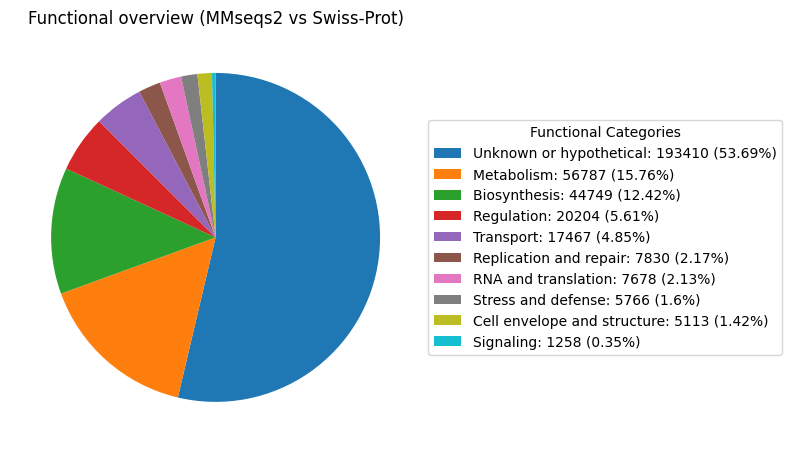

Saved results/function_summary.tsv and results/mmseqs_hits_with_categories.tsv


In [ ]:
# --- Define category rules ---
import re

CATEGORY_RULES = {
    "Metabolism": [
        r"\bmetab", r"dehydrogenase", r"oxidase", r"transferase", r"glycolysis", r"TCA", r"beta-oxidation",
        r"amino acid (biosynthesis|catabolism)", r"lipid (metabolism|biosynthesis)"
    ],
    "Biosynthesis": [
        r"\bbiosynth", r"synthase", r"synthetase", r"ligase", r"polymerase(?!.*DNA)",
        r"isoprenoid", r"cofactor biosynthesis", r"vitamin"
    ],
    "Transport": [
        r"transporter", r"permease", r"ABC transporter", r"symporter", r"antiporter", r"channel", r"porin"
    ],
    "Regulation": [
        r"regulator", r"repressor", r"activator", r"two-component", r"response regulator", r"sigma factor"
    ],
    "Replication and repair": [
        r"DNA (polymerase|ligase|helicase|repair|topoisomerase)", r"recombination", r"mismatch repair", r"nuclease"
    ],
    "RNA and translation": [
        r"ribosomal protein", r"rRNA", r"tRNA", r"translation", r"elongation factor", r"initiation factor"
    ],
    "Cell envelope and structure": [
        r"cell wall", r"peptidoglycan", r"lipopolysaccharide", r"capsule", r"membrane protein", r"flagell", r"pilus", r"fimbr"
    ],
    "Stress and defense": [
        r"stress response", r"heat shock", r"chaperone", r"detox", r"antibiotic resistance", r"efflux", r"CRISPR"
    ],
    "Signaling": [
        r"signal transduction", r"sensor kinase", r"chemotaxis", r"second messenger", r"c-di-GMP"
    ],
    "Unknown or hypothetical": [
        r"hypothetical protein", r"uncharacterized", r"putative protein", r"DUF"
    ],
}

compiled_rules = {cat: [re.compile(pat, re.IGNORECASE) for pat in pats] for cat, pats in CATEGORY_RULES.items()}

def assign_category(title):
    for cat, patterns in compiled_rules.items():
        for pat in patterns:
            if pat.search(title):
                return cat
    return "Unknown or hypothetical"

hits["category"] = hits["title"].apply(assign_category)

# --- Aggregate counts and percentages ---
import pandas as pd

cat_counts = hits["category"].value_counts().rename_axis("category").reset_index(name="count")
cat_counts["percent"] = (cat_counts["count"] / cat_counts["count"].sum() * 100).round(2)
print(cat_counts)

# --- Plot pie chart ---
import matplotlib.pyplot as plt

# Build legend labels with category, count, percent
legend_labels = [f"{row.category}: {row.count} ({row.percent}%)" for row in cat_counts.itertuples()]

plt.figure(figsize=(8, 8))
# No labels inside the pie
wedges, texts = plt.pie(cat_counts["count"], startangle=90, counterclock=False)

# Add legend outside the pie
plt.legend(wedges, legend_labels, title="Functional Categories", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Functional overview (MMseqs2 vs Swiss-Prot)")
plt.tight_layout()
plt.show()


# --- Save summaries ---
cat_counts.to_csv("results/function_summary.tsv", sep="\t", index=False)
hits.to_csv("results/mmseqs_hits_with_categories.tsv", sep="\t", index=False)
print("Saved results/function_summary.tsv and results/mmseqs_hits_with_categories.tsv")